In [ ]:
!pip install transformers==3.5
!pip install torch==1.4.0
# Restart runtime before continue

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 55.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b31cd9ecd1c3aa8a581c1b2a4277bf56999e2c37e23c9959219fa0ebd89bb247
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.4/753.4 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: to

# Import Newsgroups20 Dataset

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

newsgroups_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=RANDOM_STATE, remove=('headers', 'footers', 'quotes'))

# Let see how much data we have
n_samples = len(newsgroups_data.data)
print(f'Number of samples: {n_samples}')

# Let see our labels and map each of these labels to an index.
target_names = newsgroups_data.target_names
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(f'Class names: {target_names}')
print(label2idx)



# Extract a training & validation & test split
data = newsgroups_data.data
labels = newsgroups_data.target
print(f'Data: {data[0]}')
print(f'Label: {labels[0]}')


remain_data, val_samples, remain_labels, val_labels = train_test_split(data, labels, test_size=0.1, random_state=RANDOM_STATE)
train_samples, test_samples, train_labels, test_labels = train_test_split(remain_data, remain_labels, test_size=0.1, random_state=RANDOM_STATE)

print(f'N_train: {len(train_samples), len(train_labels)}')
print(f'N_val:   {len(val_samples), len(val_labels)}')
print(f'N_test:  {len(test_samples), len(test_labels)}')

Number of samples: 18846
Class names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
{'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'misc.forsale': 6, 'rec.autos': 7, 'rec.motorcycles': 8, 'rec.sport.baseball': 9, 'rec.sport.hockey': 10, 'sci.crypt': 11, 'sci.electronics': 12, 'sci.med': 13, 'sci.space': 14, 'soc.religion.christian': 15, 'talk.politics.guns': 16, 'talk.politics.mideast': 17, 'talk.politics.misc': 18, 'talk.religion.misc': 19}
Data: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts abou

# Using Bert pretrained

You really need a GPU to finetune BERT. Still, to make sure this code runs on any machine we'll let PyTorch determine whether a GPU is available.

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initializing a model

Google has made available a range of BERT models for us to experiment with. For English, there is a choice between three models: bert-large-uncased is the largest model that will likely give the best results. Its smaller siblings are bert-base-uncased and bert-base-cased, which are more practical to work with. For Chinese there is bert-base-chinese, and for the other languages we have bert-base-multilingual-uncased and bert-base-multilingual-cased.

Uncased means that the training text has been lowercased and accents have been stripped. This is usually better, unless you know that case information is important for your task, such as with Named Entity Recognition.

In our example, we're going to investigate sentiment analysis on English. We'll therefore use the English BERT-base model.

In [ ]:
BERT_MODEL = "bert-base-uncased"

Each model comes with its own tokenizer. This tokenizer splits texts into word pieces. In addition, we'll tell the tokenizer it should lowercase the text, as we're going to work with the uncased model.

In [ ]:
from transformers.tokenization_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
tokenizer.encode('hello world!')

[101, 7592, 2088, 999, 102]

A full BERT model consists of a common, pretrained core, and an extension on top that depends on the particular NLP task. After all, the output of a sequence classification model, where we have just one prediction for every sequence, looks very different from the output of a sequence labelling or question answering model. As we're looking at sentiment classification, we're going to use the pretrained BERT model with a final layer for sequence classification on top.

In [ ]:
from transformers.modeling_bert import BertForSequenceClassification

pretrained_model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
pretrained_model.to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Preparing the data for Bert

Next we need to prepare our data for BERT. We'll present every document as a BertInputItem object, which contains all the information BERT needs:

* a list of input ids. Take a look at the logging output to see what this 
means. Every text has been split up into subword units, which are shared between all the languages in the multilingual model. When a word appears frequently enough in a combined corpus of all languages, it is kept intact. If it is less frequent, it is split up into subword units that do occur frequently enough across all languages. This allows our model to process every text as a sequence of strings from a finite vocabulary of limited size. Note also the first [CLS] token. This token is added at the beginning of every document. The vector at the output of this token will be used by the BERT model for its sequence classification tasks: it serves as the input of the final, task-specific part of the neural network.
* the input mask: the input mask tells the model which parts of the input it should look at and which parts it should ignore. In our example, we have made sure that every text has a length of 100 tokens. This means that some texts will be cut off after 100 tokens, while others will have to be padded with extra tokens. In this latter case, these padding tokens will receive a mask value of 0, which means BERT should not take them into account for its classification task.
* the segment_ids: some NLP task take several sequences as input. This is the case for question answering, natural language inference, etc. In this case, the segment ids tell BERT which sequence every token belongs to. In a text classification task like ours, however, there's only one segment, so all the input tokens receive segment id 0.
* the label id: the id of the label for this document.

In [ ]:
# import logging
import numpy as np

# logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
#                     datefmt = '%m/%d/%Y %H:%M:%S',
#                     level = logging.INFO)
# logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

# def convert_samples_to_inputs(samples, labels, label2idx, max_seq_length, tokenizer, verbose=0):
def convert_samples_to_inputs(samples, labels, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(samples, labels)
    for (i, (text, label)) in enumerate(examples):

        # Create a list of token ids
        # input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        input_ids = tokenizer.encode(f"{text}")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_samples_to_inputs(train_samples, train_labels, MAX_SEQ_LENGTH, tokenizer)
val_features = convert_samples_to_inputs(val_samples, val_labels,  MAX_SEQ_LENGTH, tokenizer)
test_features = convert_samples_to_inputs(test_samples, test_labels,  MAX_SEQ_LENGTH, tokenizer)

Finally, we're going to initialize a data loader for our training, development and testing data. This data loader puts all our data in tensors and will allow us to iterate over them during training.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
val_dataloader = get_data_loader(val_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

## Evaluation method

Now it's time to write our evaluation method. This method takes as input a model and a data loader with the data we would like to evaluate on. For each batch, it computes the output of the model and the loss. We use this output to compute the obtained precision, recall and F-score. During training, we will print the simple numbers. When we evaluate on the test set, we will output a full classification report.

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

## Training

Now it's time to start training. We're going to use the AdamW optimizer with a base learning rate of 5e-5, and train for a maximum of 100 epochs. Here are some additional things to note:

* Gradient Accumulation allows us to keep our batches small enough to fit into the memory of our GPU, while getting the advantages of using larger batch sizes. In practice, it means we sum the gradients of several batches, before we perform a step of gradient descent.
* We use the WarmupLinearScheduler to vary our learning rate during the training process. First, we're going to start with a small learning rate, which increases linearly during the warmup stage. Afterwards it slowly decreases again.

In [ ]:
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 100
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(pretrained_model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

We're finally ready to train our model. At each epoch, we're going to train it on our training data and evaluate it on the validation data. We keep a history of the loss, and stop training when the loss on the development set doesn't improve for a certain number of steps (we call this number our patience). Whenever the development loss of our model improves, we save it.

In [ ]:
import torch
import os

from sklearn.metrics import classification_report, precision_recall_fscore_support

from functools import partial
from tqdm import trange
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_pretrained_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    pretrained_model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        # print(input_mask[0])

        outputs = pretrained_model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(pretrained_model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    val_loss, _, _ = evaluate(pretrained_model, val_dataloader)
    
    print("Loss history:", loss_history)
    print("val loss:", val_loss)
    
    if len(loss_history) == 0 or val_loss < min(loss_history):
        no_improvement = 0
        model_to_save = pretrained_model.module if hasattr(pretrained_model, 'module') else pretrained_model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(val_loss)

Evaluation iteration: 100%|██████████| 118/118 [00:10<00:00, 10.92it/s]


Loss history: []
val loss: 1.6974115573753745


Evaluation iteration: 100%|██████████| 118/118 [00:10<00:00, 10.93it/s]


Loss history: [1.6974115573753745]
val loss: 1.1816395435292841


Evaluation iteration: 100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Loss history: [1.6974115573753745, 1.1816395435292841]
val loss: 1.0302315887253164


Epoch:   4%|▍         | 4/100 [20:30<8:12:45, 307.98s/it]

Loss history: [1.6974115573753745, 1.1816395435292841, 1.0302315887253164]
val loss: 1.0654600388922935


Epoch:   4%|▍         | 4/100 [25:38<10:15:12, 384.51s/it]

Loss history: [1.6974115573753745, 1.1816395435292841, 1.0302315887253164, 1.0654600388922935]
val loss: 1.117010754043773
No improvement on development set. Finish training.


## Evaluation

Let's now evaluate the model on some documents it has never seen. We'll load our best model and have it predict the labels for all documents in our data. We'll compute its precision, recall and F-score for the training, development and test set and print a full classification report for the test set.

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, val_correct, val_predicted = evaluate(model, val_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(val_correct, val_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=target_names))

Evaluation iteration: 100%|██████████| 107/107 [00:09<00:00, 10.97it/s]

Training performance: (0.81833071278826, 0.81833071278826, 0.8183307127882601, None)
Development performance: (0.6859416445623342, 0.6859416445623342, 0.6859416445623342, None)
Test performance: (0.7100766057748968, 0.7100766057748968, 0.7100766057748968, None)
                          precision    recall  f1-score   support

             alt.atheism       0.47      0.66      0.55        85
           comp.graphics       0.69      0.65      0.67        94
 comp.os.ms-windows.misc       0.62      0.74      0.68        85
comp.sys.ibm.pc.hardware       0.64      0.72      0.68       105
   comp.sys.mac.hardware       0.75      0.64      0.69        90
          comp.windows.x       0.82      0.84      0.83        81
            misc.forsale       0.83      0.77      0.80        69
               rec.autos       0.88      0.62      0.73        86
         rec.motorcycles       0.63      0.80      0.71        86
      rec.sport.baseball       0.95      0.80      0.86        88
        rec

# BERT and Transformer

### Here is the original Transformer architecture

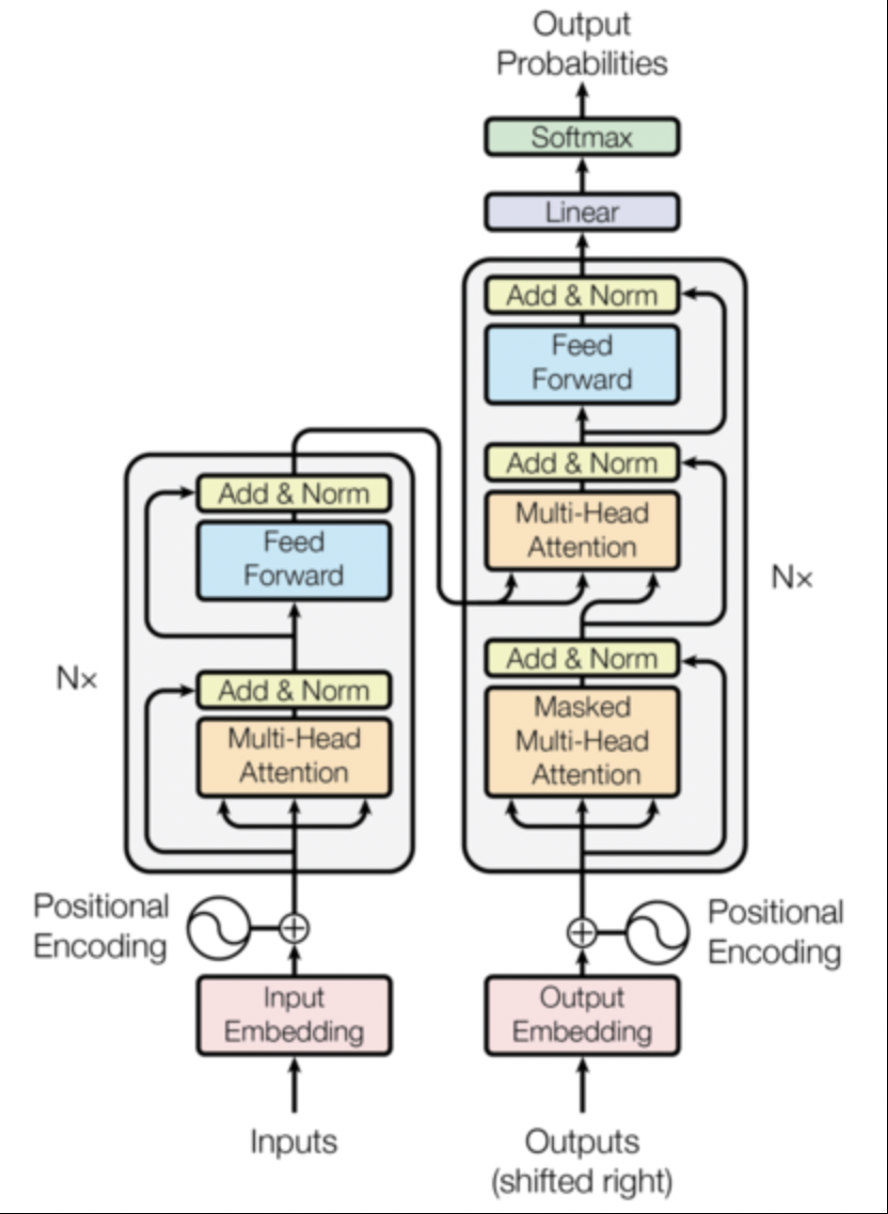

### What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers, so, as the name suggests, it is a way of learning representations of a language that uses a transformer, specifically, the encoder part of the transformer. BERT is only an encoder, while the original transformer is composed of an encoder and decoder.

Although the true BERT achitecture might be different, we can view BERT as follow

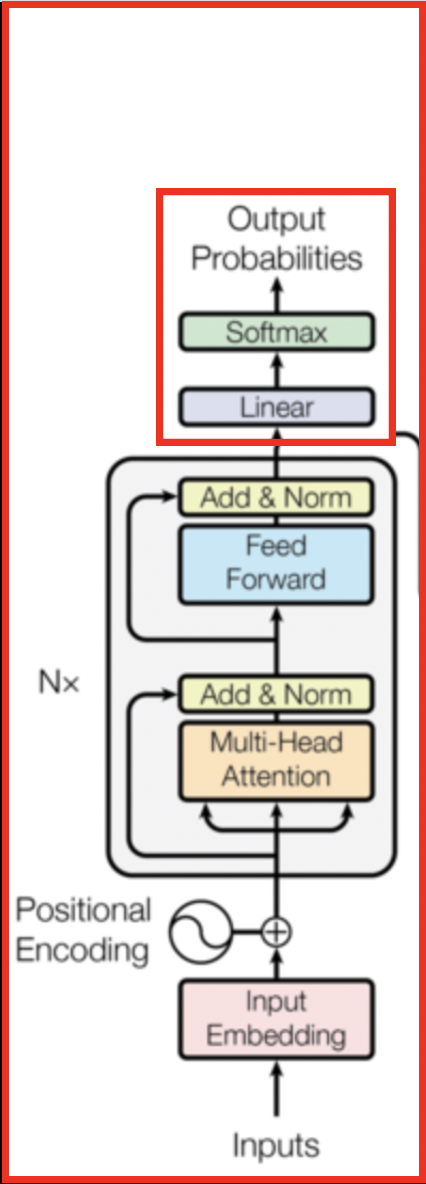

## BERT Components

### Embedding Layer

In a one-hot representation of a language, there is one vector element for each word. For a vocabulary of size N that vector is an N-dimensional space. Each word represents a point in that space, one unit away from the origin along one of the many axes.

In the Attention mechanisism, for a vocabulary size N of say 50,000, the transition matrix between all pairs of words and all potential next words would have 50,000 columns and 50,000 squared (2.5 billion) rows, totaling over 100 trillion elements. That is too much for any machine to handle effectively.

Fortunately, there is a workaround, Embeddings. In an Embedding, those word points are all taken and projected into a lower-dimensional space.

> An embedding reduces the number of parameters needed by a tremendous amount. However, the fewer the dimensions in the embedded space, the more information about the original words gets discarded. The richness of a language still requires quite a bit of space to lay out all the important concepts so that they don't step on each other's toes. By choosing the size of the embedded space, we get to trade off computational load for model accuracy.

**How can we embed from one-hot representation into a lower dimensional space??**



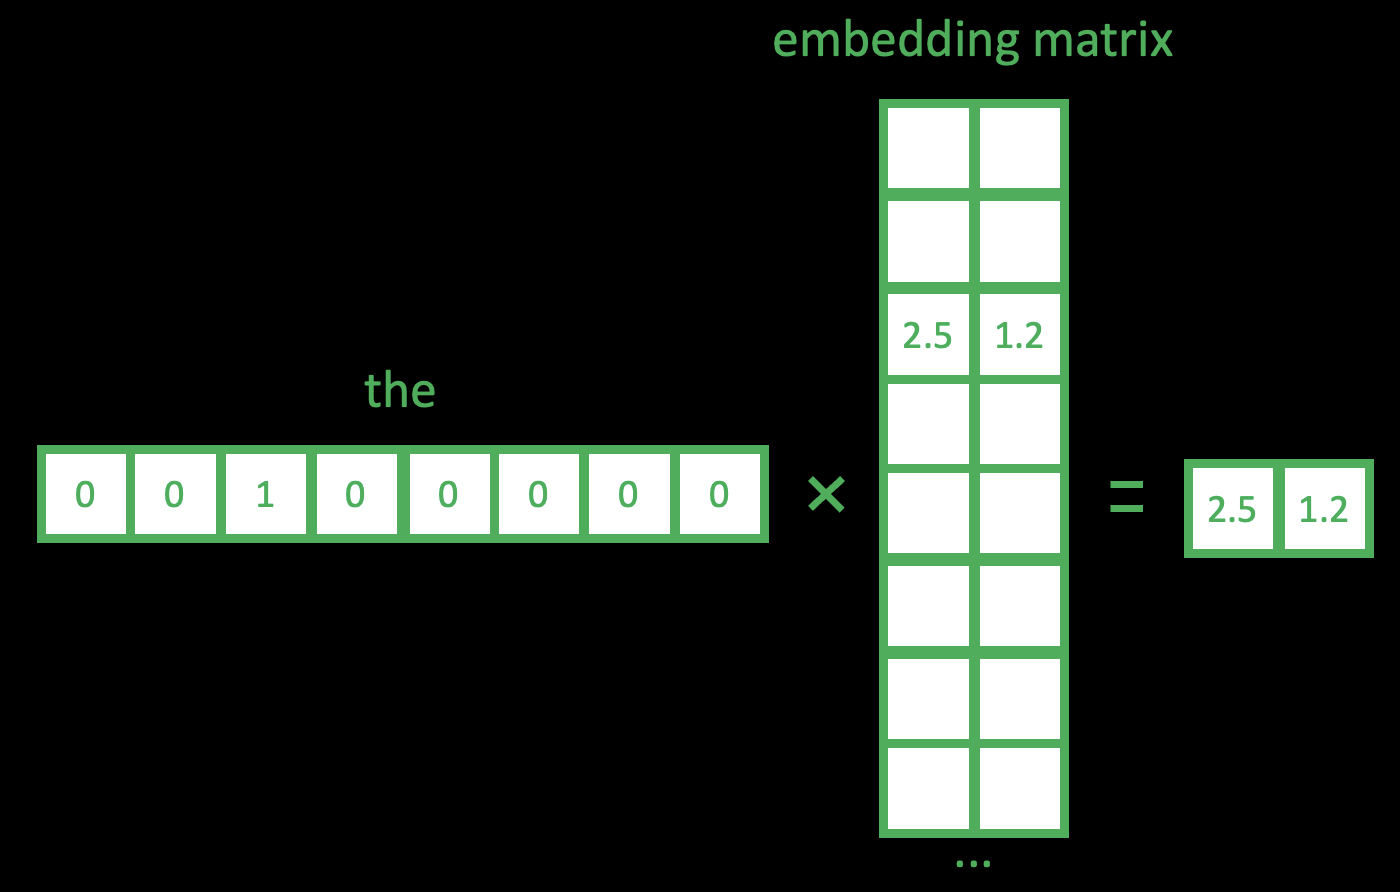

Though matrix mutiplication, projection matrices(we will call as Embedding lookup table) can convert the original collection of one-hot vocabulary vectors into any configuration in a space of whatever dimensionality you want. The biggest trick is finding a useful projection, one that has similar words grouped together, and one that has enough dimensions to spread them out.

> For the pretrained BERT above, they use Embedding size of 768



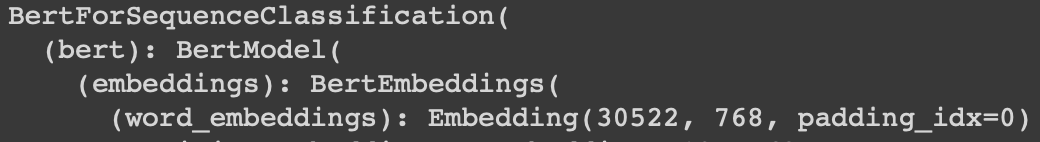

To implement this Embedding block we will use pytorch nn.Embedding layer. 

> What nn.Embedding does is using the word idx in the corpus (this act as a one-hot vector representation of the word) then perform a nn.Linear without bias (this act as our matrix multiplication)

In [ ]:
import torch.nn as nn
import math

class Embeddings(nn.Module):
    def __init__(self, vocab_len, embed_size):
        super(Embeddings, self).__init__()
        self.encode = nn.Embedding(vocab_len, embed_size)  # This is our Embedding lookup table
        self.embed_size = embed_size

    def forward(self, input):
        return self.encode(input) * math.sqrt(self.embed_size)

### Positional Encoding

The Transformer architecture ditched the recurrence mechanism in favor of multi-head self-attention mechanism, **result in massive speed-up in the training time.** As each word in a sentence simultaneously flows through the Transformer’s encoder/decoder stack, The model itself **doesn’t have any sense of position/order for each word.**

**Now we get to fix that using positional embeddings.**

> There are several ways that position information could be introduced into our embedded represetation of words, but the way it was done in the original transformer was to add a ***Sinusoid*** function to be our positional encodings.



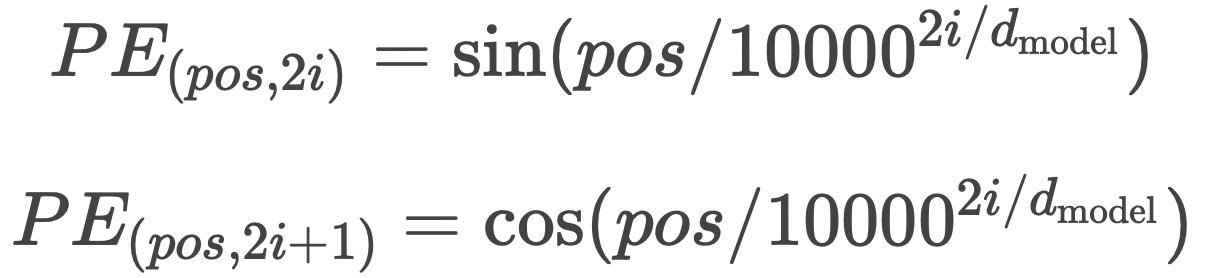

The positional encodings have the same dimension ***emb_size*** as the embeddings, so that the two can be summed.

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the Sinusoid function."

    def __init__(self, embed_size, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

#### Let have a look at what Sinusoid function give us

In [ ]:
import pandas as pd
import altair as alt

def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4,5,6,7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


example_positional()

alt.Chart(...)

### Attention Block

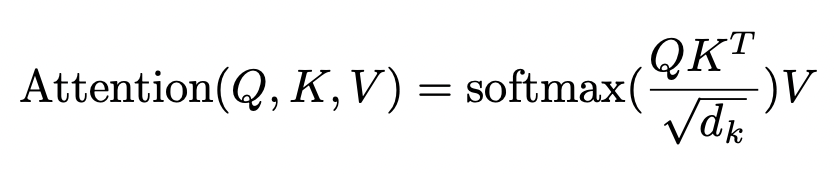

Our Attention mechanism happen in the $QK^T$ matrix mutiplication opperation. To understand why this is the case let see an example

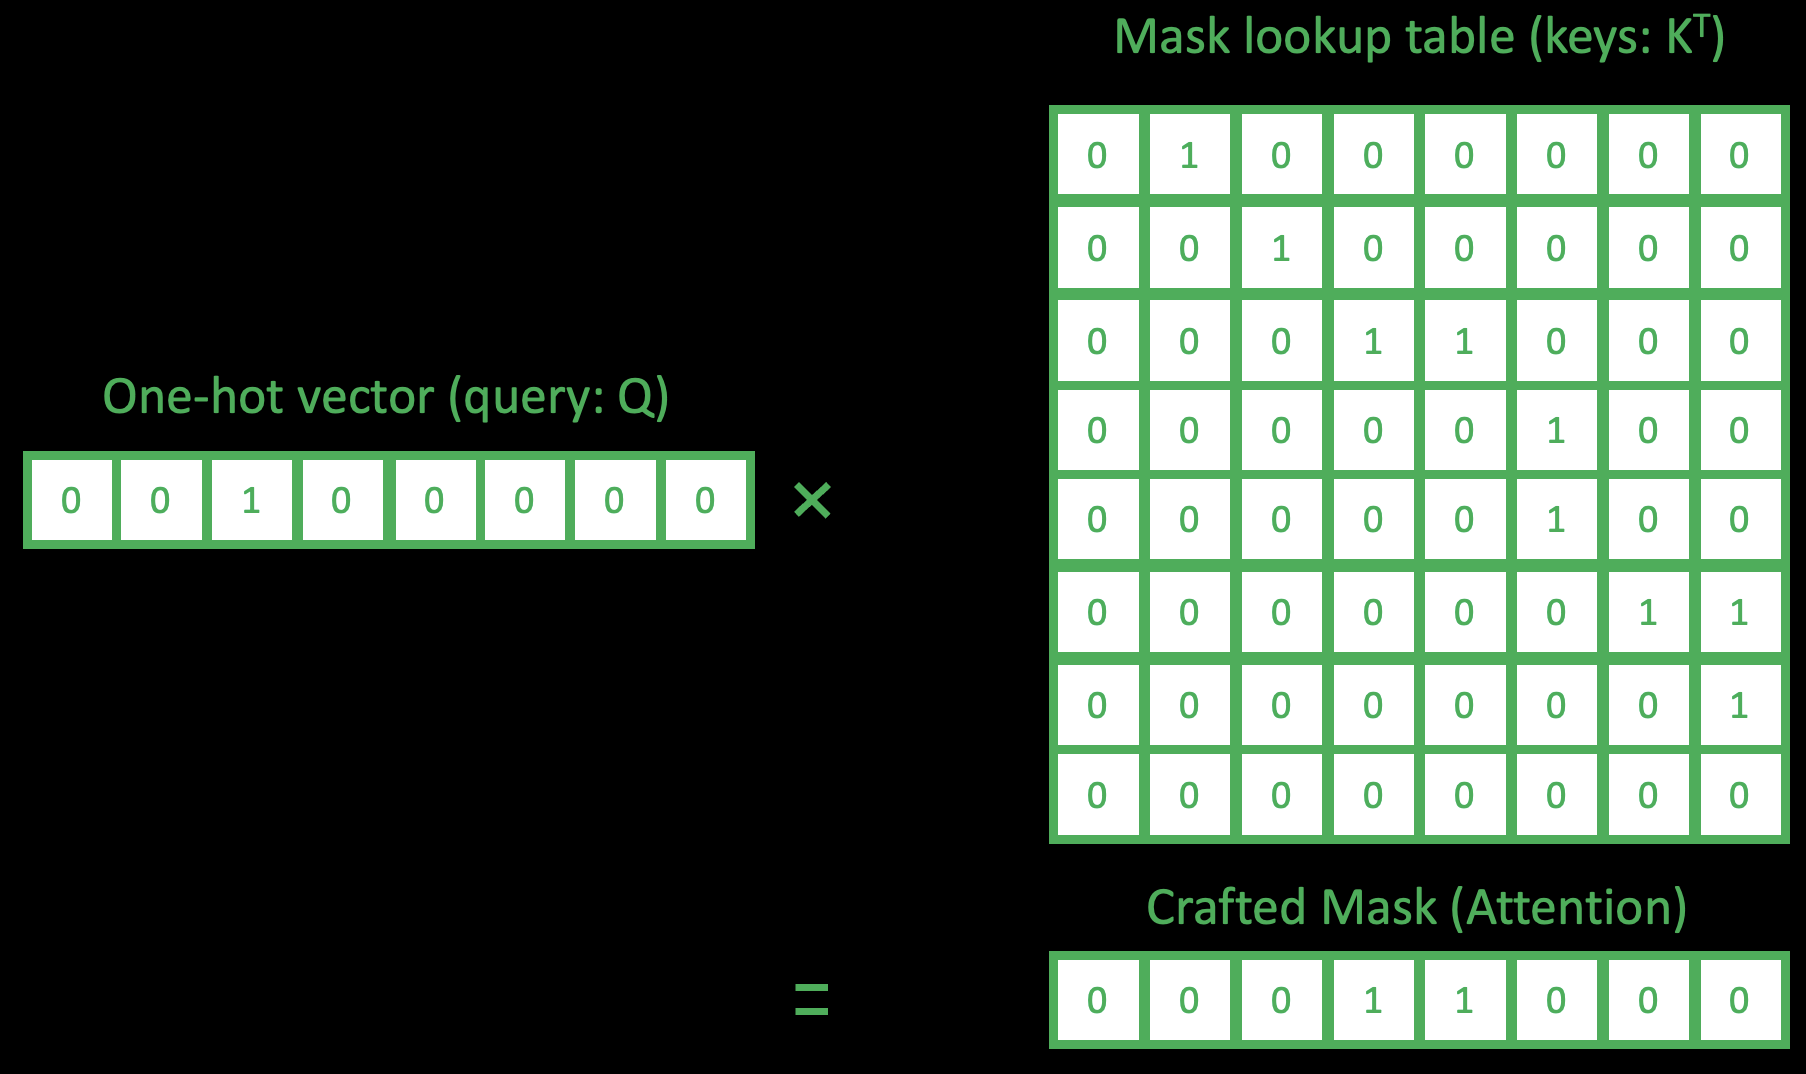

Here we only take one vector from Query: $Q$ matrix also make it an one-hot vector. When we mutiply this $Q$ vector with our $K^T$ keys matrix what we get is a vector at the third index.

> We can interpret this as Query $Q$ tell us to get 1 third keys and none others from $K^T$ keys masking table. Or "ATTENTION" 100% using the third keys

But our $Q$ vector in practise is not one-hot, let see a different example

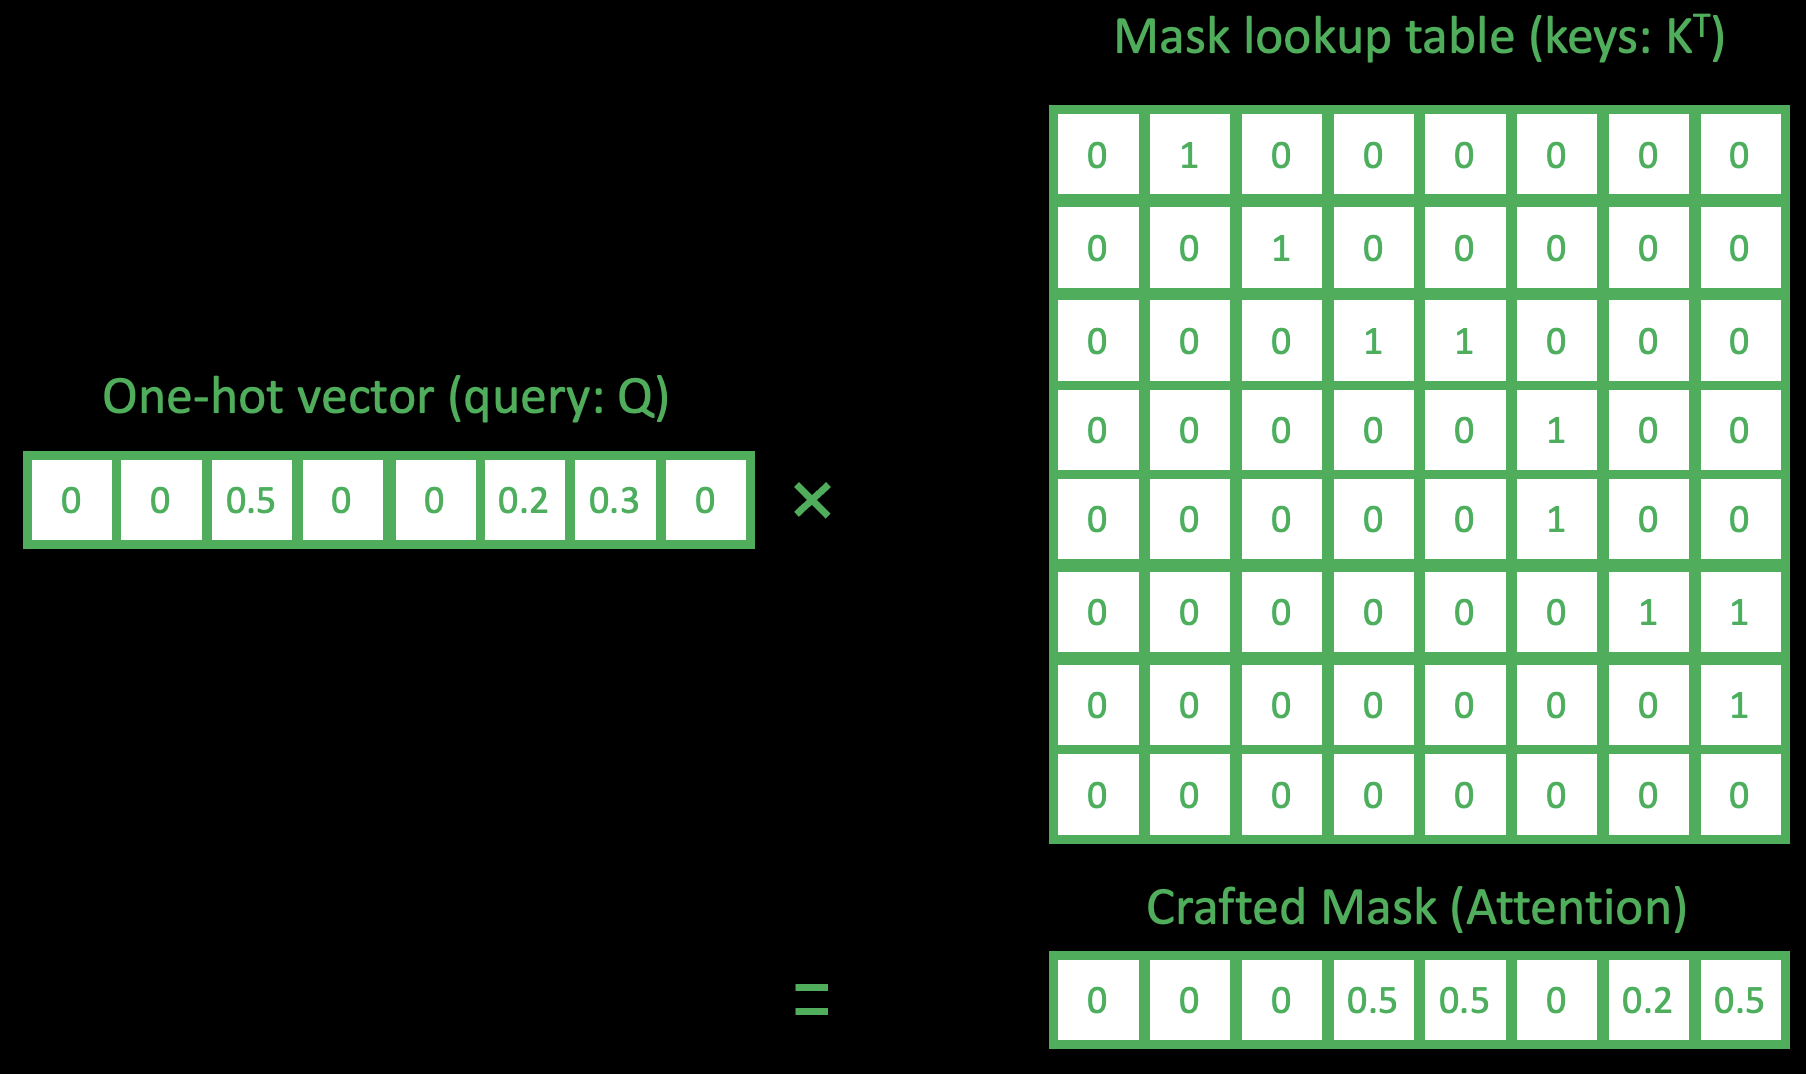

In this example, when we mutiply this $Q$ vector with our $K^T$ keys matrix what we get is a sum of $0.5$x the third vector, $0.2$x the six-th, and $0.3$x the seven-th

> We can interpret this as Query $Q$ tell us to CRAFT a new "ATTENTION" using 50% third keys, 20% six-th keys, 30% seven-th keys

##### **Why Softmax?**

The softmax is helpful here for three reasons. 

* First, it converts our $QK^T$ results vector from an arbitrary set of values to a probability distribution.
* Second, it thins the field near the top. If one scores clearly higher than the others, softmax will exaggerate that difference, making it look almost like an argmax, with the winning value close to one and all the others close to zero. However, if there are several scores that all come out close to the top, it will preserve them all as highly probable, rather than artifically crushing close second place results.
* Third, softmax is differentiable, meaning we can calculate how much each element of the results will change, given a small change in any of the input elements. This allows us to use it with backpropagation to train our transformer.

##### **Why do we need scaling? Why $\sqrt{d_k}$?**

The Softmax function is very sensitive to input values with large variance. These kill the gradient, and slow down learning, or cause it to stop altogether. Since the average value of the dot product grows with the embedding dimension k, it helps to scale the dot product back to approx Normal Distribution to stop the inputs to the softmax function from growing too large.

Imagine a vector in $ℝ^k$ with values all $c$. Its Euclidean length is $\sqrt{d_k}c$. This effectively make their dot product to have variance of $d_k$, Therefore, we are dividing out the amount by which the increase in dimension increases the length of the average vectors.



In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # [n , d_k] x [n, d_k].T = [n,n]
    mask = mask.view(-1, 1, 1, scores.shape[-1])
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

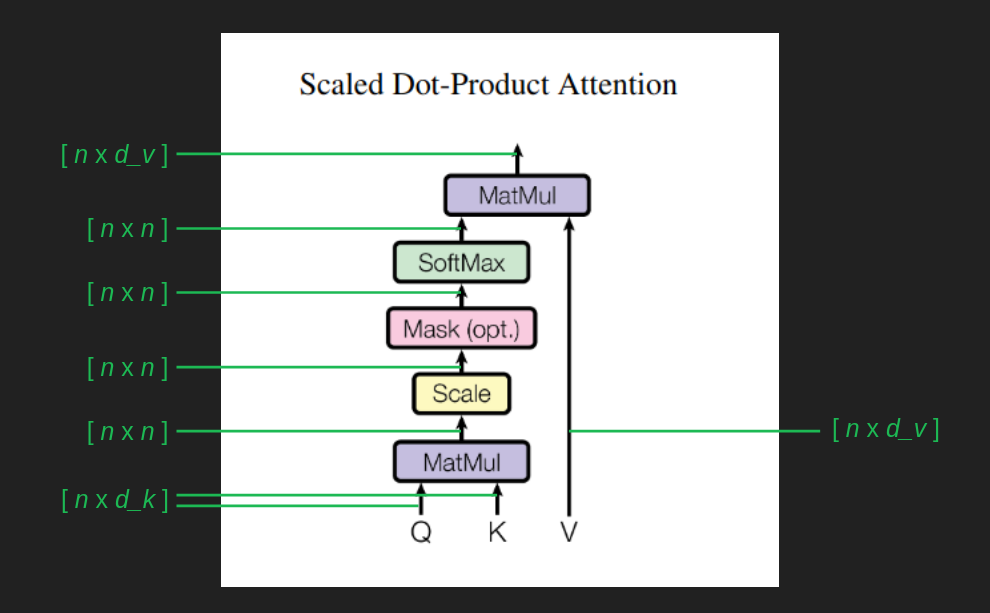

### Mutihead-Attention

#### Why we need more than one attention head?

At this point, words are represented as dense embedded vectors, rather than one-hot vectors. To get the results to fall between 0 and 1, we use the softmax trick.

An complicating consequence of putting a softmax function in attention is that it will tend to focus on a single element.

The solution is to have several different instances of attention, or heads running at once. This lets the the transformer consider several previous words simultaneously when predicting the next.

> In the pretrained BERT we used above they used 768 dimension for $Q,K,V$

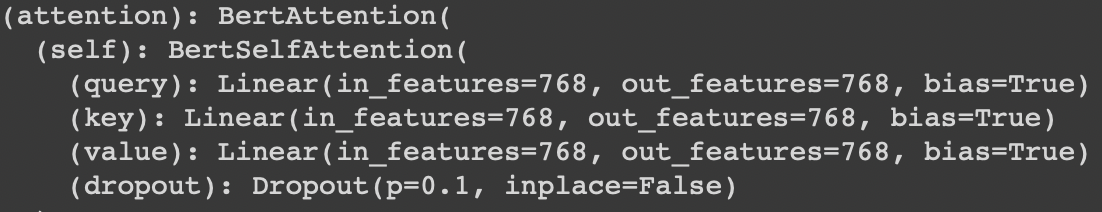

Unfortunately, doing this really increases the computational load. To get around this, in the original Transformer they projecting everything into a lower-dimensional embedding space:

* d_embed: dimensions in the tokens embedding space. 512 in the Transformer paper
* d_k: dimensions in the embedding space used for keys and queries. 64 in the Transformer paper.
* d_v: dimensions in the embedding space used for values. 64 in the Transformer paper.
* h: the number of heads. 8 in the transformer paper.

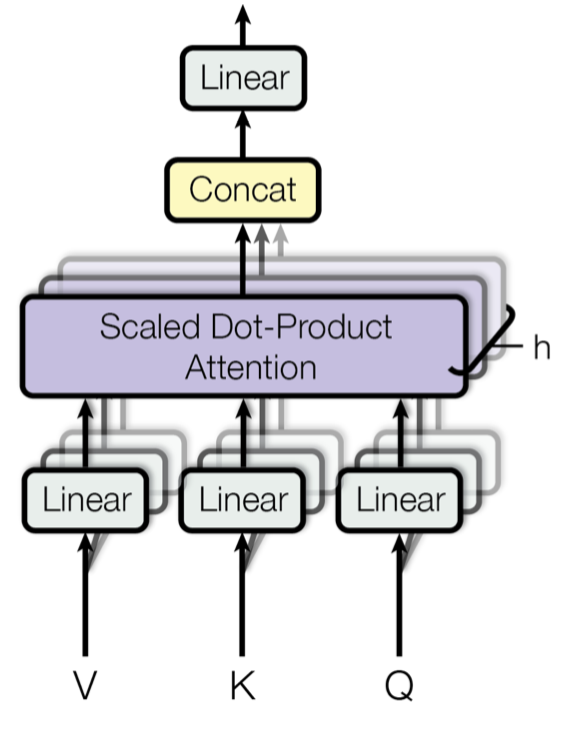

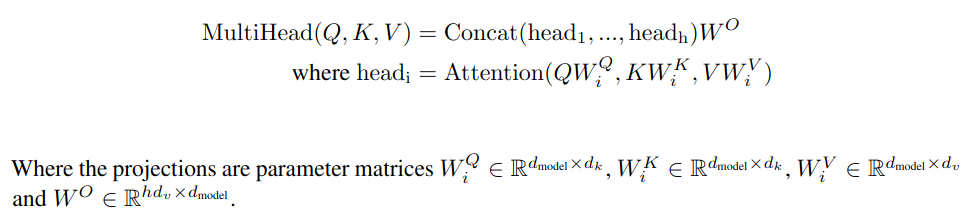

In [ ]:
# Create a helper to duplicate the layer we want
import copy

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, embed_size, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert embed_size % n_heads == 0
        # We assume d_v always equals d_k
        self.d_k = embed_size // n_heads
        self.n_heads = n_heads
        self.linears = clones(nn.Linear(embed_size, embed_size), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.n_heads, self.d_k).transpose(1, 2)   # [n , d_model] x3 -> [n , h x d_k] -> [h, n, d_k]  
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout   # softmax([n , d_k] x [n , d_k].T) x [n , d_v] = [n, d_v]
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)   # [h, n, d_v] -> [n, h, d_v]
            .contiguous()       
            .view(nbatches, -1, self.n_heads * self.d_k)  # [n, h x d_v]
        )
        del query
        del key
        del value
        return self.linears[-1](x)   # [n, h x d_v] x [h x d_v, d_model]  = [n, d_model]

### Position-wise Feed-Forward Networks

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, embed_size, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(embed_size, d_ff)
        self.w_2 = nn.Linear(d_ff, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, n):
        return self.w_2(self.dropout(self.w_1(n).relu()))

### Skip connection

Skip connections serve two purposes.

* Help keep the gradient smooth, which is a big help for backpropagation.
* Preserving the original input sequence.


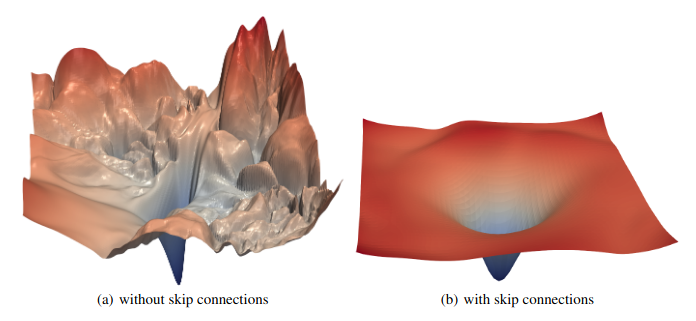

#### Layer Norm

The short version of layer normalization is that the values of the matrix are shifted to have a mean of zero and scaled to have a standard deviation of one.

The longer version is that in systems like transformers, they are inherently nonlinear, which makes them very expressive but also sensitive to signals' magnitudes and distributions. Normalization is a technique that has proven useful in maintaining a consistent distribution of signal values each step of the way throughout many-layered neural networks. It encourages convergence of parameter values and usually results in much better performance.

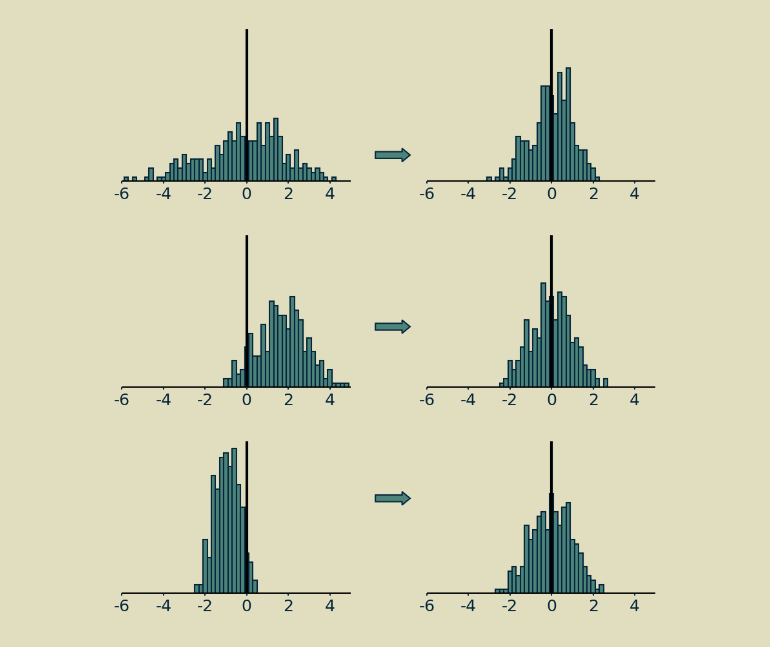

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module"

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)     
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

## Let combine all of our components into a complete model

In [ ]:
from torch.nn.functional import log_softmax
class Classifier(nn.Module):
    "Define standard linear + softmax classifier layer."

    def __init__(self, embed_size, num_class):
        super(Classifier, self).__init__()
        self.proj = nn.Linear(embed_size, num_class)

    def forward(self, x):
        # print(f'x befor classifier: {x.shape}')
        return log_softmax(self.proj(x), dim=-1)

In [ ]:
class EncoderBlock(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attn = self_attn                                    # Attention block
        self.feed_forward = feed_forward                              # FFN block
        self.sublayer = clones(SublayerConnection(size, dropout), 2)  # 2 Skip connection blocks
        self.size = size                                              # Size of the FFN linear

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:    # loop through N layers
            x = layer(x, mask)
        
        return self.norm(x)

In [ ]:
class MyBERT(nn.Module):
    """
    A standard Encoder architecture.
    """

    def __init__(self, src_embed, encoder, classifier):
        super(MyBERT, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.classifier = classifier


    def encode(self, src, src_mask):
        embed = self.src_embed(src)
        return self.encoder(embed, src_mask)


    def forward(self, src, src_mask):
        "Take in and process masked src."
        encode_out = self.encode(src, src_mask)
        
        class_prob = self.classifier(encode_out[:, -1])
        return class_prob

In [ ]:
def make_model(vocab_len, num_class, N=6, embed_size=512, d_ff=2048, n_heads=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(n_heads, embed_size)
    ff = PositionwiseFeedForward(embed_size, d_ff, dropout)
    position = PositionalEncoding(embed_size, dropout)
    model = MyBERT(
        nn.Sequential(Embeddings(vocab_len, embed_size), c(position)),
        Encoder(EncoderBlock(embed_size, c(attn), c(ff), dropout), N),
        Classifier(embed_size, num_class),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Training

In [ ]:
# We will re-use BertTokenizer for consistency between models
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

In [ ]:
# We will also re-used the DataLoader
BATCH_SIZE = 16

train_features = convert_samples_to_inputs(train_samples, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
val_features = convert_samples_to_inputs(val_samples, val_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_samples_to_inputs(test_samples, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
val_dataloader = get_data_loader(val_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

TypeError: ignored

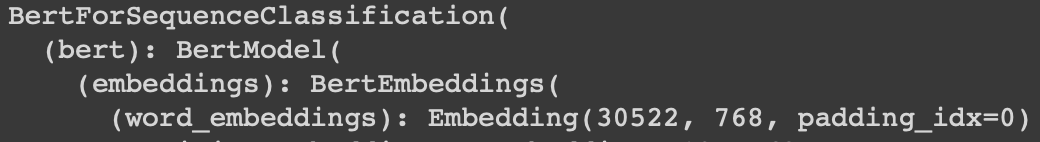

In [ ]:
# We need to use the same vocab len as the pretrained BERT 
# Cause we use it tokenizer
vocab_len = 30522
n_class = 20

custom_model = make_model(vocab_len, n_class, embed_size=768)
custom_model.to(device)

MyBERT(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=768, out_features=768, bias=True)
            (1): Linear(in_features=768, out_features=768, bias=True)
            (2): Linear(in_features=768, out_features=768, bias=True)
            (3): Linear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=768, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
       

In [ ]:
## Same training scheme

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 100
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(custom_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            logits = model(input_ids, input_mask)
            
            tmp_eval_loss = loss_fn(logits, label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [ ]:
OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_custom_model.bin"
PATIENCE = 5

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    custom_model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        outputs = custom_model(input_ids, input_mask)

        loss = loss_fn(outputs, label_ids)


        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS   # loss / n + loss / n

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(custom_model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()   
            scheduler.step()
            
    val_loss, _, _ = evaluate(custom_model, val_dataloader)
    
    print("Loss history:", loss_history)
    print("val loss:", val_loss)
    
    if len(loss_history) == 0 or val_loss < min(loss_history):
        no_improvement = 0
        model_to_save = custom_model.module if hasattr(custom_model, 'module') else custom_model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(val_loss)

Evaluation iteration: 100%|██████████| 118/118 [00:04<00:00, 25.96it/s]


Loss history: []
val loss: 3.0001910298557606


Evaluation iteration: 100%|██████████| 118/118 [00:04<00:00, 26.07it/s]


Loss history: [3.0001910298557606]
val loss: 2.942052233017097


Evaluation iteration: 100%|██████████| 118/118 [00:04<00:00, 26.04it/s]


Loss history: [3.0001910298557606, 2.942052233017097]
val loss: 1.7928249169204196


Evaluation iteration: 100%|██████████| 118/118 [00:04<00:00, 25.94it/s]


Loss history: [3.0001910298557606, 2.942052233017097, 1.7928249169204196]
val loss: 1.4975836822542095


Epoch:   5%|▌         | 5/100 [11:18<3:34:22, 135.39s/it]

Loss history: [3.0001910298557606, 2.942052233017097, 1.7928249169204196, 1.4975836822542095]
val loss: 1.594974066998999


Epoch:   6%|▌         | 6/100 [13:33<3:31:51, 135.23s/it]

Loss history: [3.0001910298557606, 2.942052233017097, 1.7928249169204196, 1.4975836822542095, 1.594974066998999]
val loss: 1.8853962929066965


Epoch:   7%|▋         | 7/100 [15:48<3:29:21, 135.07s/it]

Loss history: [3.0001910298557606, 2.942052233017097, 1.7928249169204196, 1.4975836822542095, 1.594974066998999, 1.8853962929066965]
val loss: 2.127644904084125


Epoch:   8%|▊         | 8/100 [18:02<3:26:52, 134.92s/it]

Loss history: [3.0001910298557606, 2.942052233017097, 1.7928249169204196, 1.4975836822542095, 1.594974066998999, 1.8853962929066965, 2.127644904084125]
val loss: 2.5769542152598754


Epoch:   8%|▊         | 8/100 [20:17<3:53:18, 152.16s/it]

Loss history: [3.0001910298557606, 2.942052233017097, 1.7928249169204196, 1.4975836822542095, 1.594974066998999, 1.8853962929066965, 2.127644904084125, 2.5769542152598754]
val loss: 2.610094292689178
No improvement on development set. Finish training.


In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
custom_model = make_model(vocab_len, n_class, embed_size=768)
custom_model.load_state_dict(model_state_dict)
custom_model.to(device)

custom_model.eval()

_, train_correct, train_predicted = evaluate(custom_model, train_dataloader)
_, val_correct, val_predicted = evaluate(custom_model, val_dataloader)
_, test_correct, test_predicted = evaluate(custom_model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(val_correct, val_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

custom_model_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=target_names))

Evaluation iteration: 100%|██████████| 107/107 [00:04<00:00, 25.77it/s]


Training performance: (0.7277908805031447, 0.7277908805031447, 0.7277908805031447, None)
Development performance: (0.5787798408488064, 0.5787798408488064, 0.5787798408488064, None)
Test performance: (0.6016499705362405, 0.6016499705362405, 0.6016499705362405, None)
                          precision    recall  f1-score   support

             alt.atheism       0.48      0.41      0.44        85
           comp.graphics       0.40      0.78      0.53        94
 comp.os.ms-windows.misc       0.72      0.62      0.67        85
comp.sys.ibm.pc.hardware       0.61      0.54      0.57       105
   comp.sys.mac.hardware       0.51      0.70      0.59        90
          comp.windows.x       0.74      0.64      0.69        81
            misc.forsale       0.62      0.77      0.68        69
               rec.autos       0.62      0.50      0.55        86
         rec.motorcycles       0.65      0.69      0.67        86
      rec.sport.baseball       0.85      0.60      0.71        88
       

# Model comparision

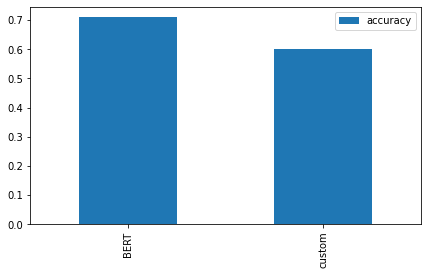

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"accuracy": {"custom": custom_model_accuracy, "BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")